In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [3]:
# Paths
RAW_PATH = Path("../data/raw/")
PROCESSED_PATH = Path("../data/processed/")
FIGURE_PATH = Path("../outputs/figures/")
MODEL_PATH = Path("../outputs/models/")

PROCESSED_PATH.mkdir(parents=True, exist_ok=True)
FIGURE_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
datasets = ["FD001", "FD002", "FD003", "FD004"]

# Feature and label columns
feature_cols = [
    "operational_setting_1", "operational_setting_2", "operational_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]  # sensor_1 to sensor_21

label_col = "label"  # binary near-failure label

In [18]:
def load_processed_data(dataset):
    """Load processed dataset and add binary label."""
    train = pd.read_csv(PROCESSED_PATH / f"train_{dataset}.csv")
    train["label"] = (train["RUL"] <= 30).astype(int)  # 1 = near-failure
    return train

def split_train_val(train_df):
    """Split dataset by engine units so validation engines are unseen."""
    units = train_df["unit_number"].unique()
    train_units, val_units = train_test_split(units, test_size=0.2, random_state=42)
    
    X_train = train_df[train_df.unit_number.isin(train_units)][feature_cols]
    y_train = train_df[train_df.unit_number.isin(train_units)][label_col]
    X_val = train_df[train_df.unit_number.isin(val_units)][feature_cols]
    y_val = train_df[train_df.unit_number.isin(val_units)][label_col]
    
    return X_train, X_val, y_train, y_val

In [7]:
# Three best models we want to compare
classifiers = {
    "XGBoost": XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        random_state=42, use_label_encoder=False, eval_metric='logloss'
    ),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42)
}

In [ ]:
def run_pipeline(dataset):
    print(f"\n=== Processing {dataset} ===")
    
    # Load and preprocess
    train_df = load_processed_data(dataset)
    X_train, X_val, y_train, y_val = split_train_val(train_df)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    results = []
    
    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_val_scaled)
        
        results.append({
            "Classifier": name,
            "Accuracy": accuracy_score(y_val, y_pred),
            "Precision": precision_score(y_val, y_pred),
            "Recall": recall_score(y_val, y_pred),
            "F1": f1_score(y_val, y_pred)
        })
        
        # Save confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"{dataset} {name} Confusion Matrix")
        plt.close()
        
        # Save model & scaler
        joblib.dump(clf, MODEL_PATH / f"{dataset}_{name}.pkl")
        joblib.dump(scaler, MODEL_PATH / f"{dataset}_scaler.pkl")
    
    return pd.DataFrame(results)

In [ ]:
all_results = {}

for ds in datasets:
    results_df = run_pipeline(ds)
    all_results[ds] = results_df
    print(f"\nMetrics for {ds}:")
    display(results_df)


=== Processing FD001 ===


d:\ai_predictive_maintenance\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2480, number of negative: 14081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 16561, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149749 -> initscore=-1.736568
[LightGBM] [Info] Start training from score -1.736568

Metrics for FD001:


d:\ai_predictive_maintenance\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Classifier,Accuracy,Precision,Recall,F1
0,XGBoost,0.964128,0.898990,0.861290,0.879736
1,Random Forest,0.964619,0.904762,0.858065,0.880795
2,LightGBM,0.963636,0.892027,0.866129,0.878887



=== Processing FD002 ===


d:\ai_predictive_maintenance\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 6448, number of negative: 37016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3774
[LightGBM] [Info] Number of data points in the train set: 43464, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148353 -> initscore=-1.747580
[LightGBM] [Info] Start training from score -1.747580

Metrics for FD002:


d:\ai_predictive_maintenance\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Classifier,Accuracy,Precision,Recall,F1
0,XGBoost,0.954930,0.896957,0.804591,0.848267
1,Random Forest,0.955901,0.905462,0.802109,0.850658
2,LightGBM,0.956775,0.896130,0.818859,0.855754



=== Processing FD003 ===


d:\ai_predictive_maintenance\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:09:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2480, number of negative: 17532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3111
[LightGBM] [Info] Number of data points in the train set: 20012, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123926 -> initscore=-1.955769
[LightGBM] [Info] Start training from score -1.955769

Metrics for FD003:


d:\ai_predictive_maintenance\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Classifier,Accuracy,Precision,Recall,F1
0,XGBoost,0.968139,0.901024,0.851613,0.875622
1,Random Forest,0.968564,0.912587,0.841935,0.875839
2,LightGBM,0.966653,0.891709,0.850000,0.870355



=== Processing FD004 ===


d:\ai_predictive_maintenance\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:09:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 6169, number of negative: 43125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3812
[LightGBM] [Info] Number of data points in the train set: 49294, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125147 -> initscore=-1.944566
[LightGBM] [Info] Start training from score -1.944566

Metrics for FD004:


d:\ai_predictive_maintenance\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Classifier,Accuracy,Precision,Recall,F1
0,XGBoost,0.952321,0.805486,0.833548,0.819277
1,Random Forest,0.954329,0.820562,0.829032,0.824775
2,LightGBM,0.952907,0.803692,0.842581,0.822677


In [12]:
combined_results = []
for ds, df in all_results.items():
    df = df.copy()
    df["Dataset"] = ds
    combined_results.append(df)

combined_results = pd.concat(combined_results, ignore_index=True)

In [13]:
combined_results

,Classifier,Accuracy,Precision,Recall,F1,Dataset
0,XGBoost,0.964128,0.898990,0.861290,0.879736,FD001
1,Random Forest,0.964619,0.904762,0.858065,0.880795,FD001
2,LightGBM,0.963636,0.892027,0.866129,0.878887,FD001
3,XGBoost,0.954930,0.896957,0.804591,0.848267,FD002
4,Random Forest,0.955901,0.905462,0.802109,0.850658,FD002
5,LightGBM,0.956775,0.896130,0.818859,0.855754,FD002
6,XGBoost,0.968139,0.901024,0.851613,0.875622,FD003
7,Random Forest,0.968564,0.912587,0.841935,0.875839,FD003
8,LightGBM,0.966653,0.891709,0.850000,0.870355,FD003
9,XGBoost,0.952321,0.805486,0.833548,0.819277,FD004


In [14]:
best_models = combined_results.loc[combined_results.groupby("Dataset")["F1"].idxmax()].reset_index(drop=True)

print("Best models per dataset:\n")
display(best_models)

Best models per dataset:



,Classifier,Accuracy,Precision,Recall,F1,Dataset
0,Random Forest,0.964619,0.904762,0.858065,0.880795,FD001
1,LightGBM,0.956775,0.896130,0.818859,0.855754,FD002
2,Random Forest,0.968564,0.912587,0.841935,0.875839,FD003
3,Random Forest,0.954329,0.820562,0.829032,0.824775,FD004


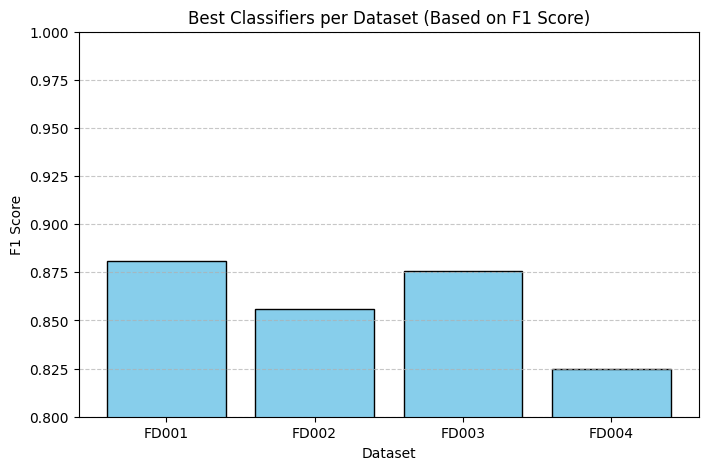

In [20]:
plt.figure(figsize=(8,5))
plt.bar(best_models["Dataset"], best_models["F1"], color="skyblue", edgecolor="black")
plt.title("Best Classifiers per Dataset (Based on F1 Score)")
plt.ylabel("F1 Score")
plt.xlabel("Dataset")
plt.ylim(0.80, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(FIGURE_PATH / "best_classifiers_f1.png")
plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

all_results = {}

for ds in datasets:
    print(f"\nRunning Random Forest for {ds}...")

    # Load processed dataset
    train_df = load_processed_data(ds)

    # Split into train/val sets
    X_train, X_val, y_train, y_val = split_train_val(train_df)

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Predictions
    y_pred = rf.predict(X_val)

    # Metrics
    results = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1-score": f1_score(y_val, y_pred)
    }
    all_results[ds] = results

    print(f"Metrics for {ds}:")
    print(results)



Running Random Forest for FD001...
Metrics for FD001:
{'Accuracy': 0.9646191646191646, 'Precision': 0.9006734006734006, 'Recall': 0.8629032258064516, 'F1-score': 0.8813838550247117}

Running Random Forest for FD002...
Metrics for FD002:
{'Accuracy': 0.9559009227780476, 'Precision': 0.9032033426183844, 'Recall': 0.8045905707196029, 'F1-score': 0.8510498687664042}

Running Random Forest for FD003...
Metrics for FD003:
{'Accuracy': 0.9679269328802039, 'Precision': 0.9092495636998255, 'Recall': 0.8403225806451613, 'F1-score': 0.8734283319362951}

Running Random Forest for FD004...
Metrics for FD004:
{'Accuracy': 0.9533249686323714, 'Precision': 0.8179487179487179, 'Recall': 0.8232258064516129, 'F1-score': 0.8205787781350482}
